# Água Rasa 2D

Main computation loop done!
Execution time: 0.14 s
Courant number 0.31


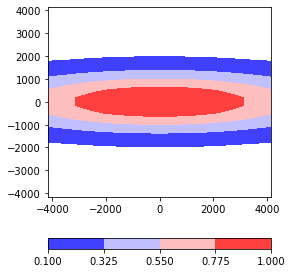

In [28]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imageio.v2 as imageio
from functions import *
import os

# Physics parameters --------------------------------
g = 9.80665         # Gravity acceleration [m/s^2]
H = 250               # Height of the fluid [m]
c = np.sqrt(g*H)

# Conditions
Nx, Ny, dx, dy, Nt, dt, lat, Nrx, Nry  = 25, 25, 160, 160, 1000, 1, -20, 10, 4
"""
scen1: f=0
scen2: f at -20 degrees as lat
scen3: beta variation between -4000 to 4000
"""

if c*dt/dx <= 0.35:
    scen, x, y, X, Y, u, v, h, Fu, f, div, vor = conditions('scen1',lat, Nx, Ny, dx, dy, Nt, Nrx, Nry)
    # Initial conditions for u, v, & h
    # --------------------------------
    u[0, :, :] = 0.
    v[0, :, :] = 0.
    h[0, :, :] = 0.
    u, v, h, div, vor = leapfrog(Nx, Ny, Nt, u, v, h, g, dx, dy, dt, H, Fu, f, c, div, vor)
        
else:
    print("Oops! CFL > 0.35. Reduce dt or dx, dy")

t_0 = time.perf_counter()  # For timing the computation loop

# Plots -------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(4,5))
im = ax.contourf(X, Y, Fu[0,:,:], cmap='bwr',levels=list(np.linspace(0.1,1,5)))
fig.colorbar(im, ax=ax, orientation='horizontal') # pad, shrink
fig.savefig("fig/fonte_u.png", dpi = 300, bbox_inches='tight', facecolor='w')
# -------------------------------------------------------------------------------
print("Main computation loop done!\nExecution time: {:.2f} s".format(time.perf_counter() - t_0))
print("Courant number {:.2f}".format(c*dt/dx))

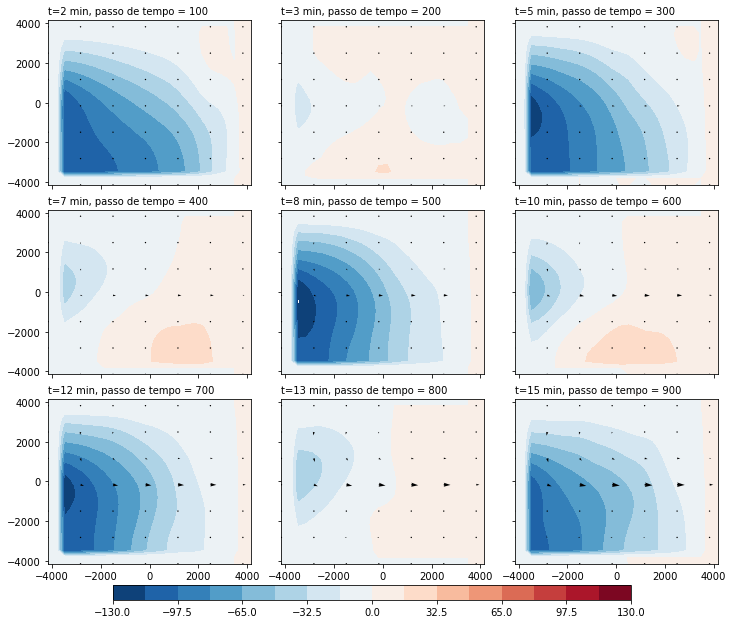

In [37]:
# Arrows
staged_u = np.zeros((Nt+1, Nx+1, Ny+1))
staged_v = np.zeros((Nt+1, Nx+1, Ny+1))

staged_u[:, :, :] = (u[:, 1:, :] + u[:, :-1, :]) * 0.5
staged_v[:, :, :] = (v[:, :, 1:] + v[:, :, :-1]) * 0.5
lvs = list(np.linspace(-130,130,17))
    
fig, axes = plt.subplots(3,3, figsize=(12,10), sharex=True, sharey=True, gridspec_kw={'wspace':0.15, 'hspace':0.15} )
for ax, n in zip(axes.flatten(), list(range(100,901,100))):
    im = ax.contourf(X, Y, h[n,:,:], cmap=plt.cm.RdBu_r, levels=lvs)
    #cbar = fig.colorbar(im, ax=ax, orientation="vertical")
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], staged_u[n,::4, ::4], staged_v[n,::4, ::4],
        units = "xy", scale = 2)
    #qk = ax.quiverkey(Q, 0.9, 0.8, 1000, "0.1 m/s", labelpos = "E", coordinates = "figure")
    ax.set_title("t={:.0f} min, passo de tempo = {:.0f}".format(dt*n/60, n), fontsize=10, loc='left')
cax = fig.add_axes([.2,.075,.6,.02]) # left, bottom, width, height
fig.colorbar(im, cax=cax, orientation='horizontal') # pad, shrink
fig.savefig("fig/leapfrog_250m_"+scen+".png", dpi = 300, bbox_inches='tight', facecolor='w')


In [38]:
filenames = []
# plot the line chart
    
for n in range(1,Nt,2):
    fig, ax = plt.subplots()
    im = ax.contourf(X, Y, h[n,:,:], cmap=plt.cm.RdBu_r, levels=lvs)
    fig.colorbar(im, ax=ax, orientation="vertical")
    ax.set_title("t={:.0f} min, passo de tempo = {:.0f}".format(dt*n/60, n), fontsize=10, loc='left')
    Q = ax.quiver(X[::4, ::4], Y[::4, ::4], u[n,::4, ::4], v[n,::4, ::4], units = "xy", scale = 1)

    # create file name and append it to a list
    filename = f'fig/gifs/{n}.png'
    filenames.append(filename)

    # save frame
    fig.savefig(filename, dpi=200)
    plt.close() # build gif

with imageio.get_writer('gifs/leap_250m_'+scen+'.gif', mode='I', duration = 0) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    
# Remove files
for filename in set(filenames):
    os.remove(filename)  